### Imports

In [1]:
from pathlib import Path
import os
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import pickle as pkl

from omegaconf import OmegaConf as omcon


import torch

import sys
sys.path.append("..") # root of repo
sys.path.append("/nfs/home/rhotertj/Code/thesis/src")
import src.multimodal_transforms as mmt
from src.lit_models import LitModel, weighted_cross_entropy, unweighted_cross_entropy, twin_head_loss, Cache
from src.video_models import make_kinetics_mvit
from src.graph_models import GAT, PositionTransformer, GIN
from src.multimodal_models import MultiModalModel
from src.lit_data import LitMultiModalHblDataset, LitResampledHblDataset, collate_function_builder
from src.data import LabelDecoder
from src.utils import get_proportions_df


/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Load models and dataset

In [2]:
# POSITION MODEL
positions_ckpt_dir = Path("/nfs/home/rhotertj/Code/thesis/experiments/input_format/posiformer_indicator_shuffle_long")

positions_ckpt_file = [f for f in os.listdir(positions_ckpt_dir) if f.endswith(".ckpt")][-1]
print("Loading", positions_ckpt_file)
positions_config = omcon.load(positions_ckpt_dir / "config.yaml")
positions_cache = Cache()
positions_cache.load(positions_ckpt_dir / "test_results.pkl")

# remove pretrained model weights, they are overwritten anyways by lightning checkpoint
if positions_config.model.name == "MultiModalModel":
    positions_config.model.params.video_model_ckpt = ""
    positions_config.model.params.graph_model_ckpt = ""

loss_func = eval(positions_config.loss_func)
label_decoder = LabelDecoder(positions_config.num_classes)
positions_config.data.params.batch_size = 1

lit_dataset = eval(positions_config.data.name)(**positions_config.data.params, label_mapping=label_decoder)
lit_dataset.setup("test")
val_loader = lit_dataset.test_dataloader()
dataset = lit_dataset.data_test

base_path = Path(".") / "analysis" / positions_ckpt_dir.name
if not os.path.exists(base_path):
    os.makedirs(base_path)

positions_model = eval(positions_config.model.name)(**positions_config.model.params,  num_classes=positions_config.num_classes, batch_size=positions_config.data.params.batch_size)
print(positions_config.model.name)
positions_lit_model = LitModel.load_from_checkpoint(
    positions_ckpt_dir / positions_ckpt_file,
    optimizer=None,
    scheduler=None,
    loss_func=loss_func,
    model=positions_model,
    label_mapping=label_decoder,
    experiment_dir=base_path
)
positions_lit_model = positions_lit_model.eval()
if torch.cuda.is_available():
    print("GPU!")
    positions_lit_model.cuda()
else:
    print("CPU")


Loading epoch=20-val_acc=0.84.ckpt
Read /nfs/home/rhotertj/datasets/hbl/meta30_test.csv
PositionTransformer
CPU


In [3]:
# VIDEO MODEL
video_ckpt_dir = Path("/nfs/home/rhotertj/Code/thesis/experiments/architecture/mvit_twin")

video_ckpt_file = [f for f in os.listdir(video_ckpt_dir) if f.endswith(".ckpt")][-1]
print("Loading", video_ckpt_file)
video_config = omcon.load(video_ckpt_dir / "config.yaml")
video_cache = Cache()
video_cache.load(video_ckpt_dir / "test_results.pkl")

# remove pretrained model weights, they are overwritten anyways by lightning checkpoint
if video_config.model.name == "MultiModalModel":
    video_config.model.params.video_model_ckpt = ""
    video_config.model.params.graph_model_ckpt = ""

loss_func = eval(video_config.loss_func)
label_decoder = LabelDecoder(video_config.num_classes)
video_config.data.params.batch_size = 1

lit_dataset = eval(video_config.data.name)(**video_config.data.params, label_mapping=label_decoder)
lit_dataset.setup("test")
val_loader = lit_dataset.test_dataloader()
dataset = lit_dataset.data_test

base_path = Path(".") / "analysis" / video_ckpt_dir.name
if not os.path.exists(base_path):
    os.makedirs(base_path)

video_model = eval(video_config.model.name)(**video_config.model.params,  num_classes=video_config.num_classes, batch_size=video_config.data.params.batch_size)
print(video_config.model.name)
video_lit_model = LitModel.load_from_checkpoint(
    video_ckpt_dir / video_ckpt_file,
    optimizer=None,
    scheduler=None,
    loss_func=loss_func,
    model=video_model,
    label_mapping=label_decoder,
    experiment_dir=base_path
)
video_lit_model = video_lit_model.eval()
if torch.cuda.is_available():
    print("GPU!")
    video_lit_model.cuda()
else:
    print("CPU")

Loading epoch=9-val_acc=0.75.ckpt
Read /nfs/home/rhotertj/datasets/hbl/meta30_test.csv
make_kinetics_mvit
CPU


In [4]:
base_path = Path(".") / "analysis" / "comparison"
if not os.path.exists(base_path):
    os.makedirs(base_path)


### Confusion

In [5]:
p_df = pd.DataFrame(positions_cache.data)
v_df = pd.DataFrame(video_cache.data)
p_df["correct"] = False
v_df["correct"] = False
p_df.loc[p_df["ground_truths"] == p_df["predictions"], "correct"] = True
v_df.loc[v_df["ground_truths"] == v_df["predictions"], "correct"] = True
assert len(p_df) == len(v_df)

In [6]:
print("Position Accuracy:", len(p_df[p_df["correct"] == True]) / len(p_df))
print("Video Accuracy:", len(v_df[v_df["correct"] == True]) / len(v_df))

Position Accuracy: 0.8514752068611463
Video Accuracy: 0.7691799540979646


In [7]:
v_correct = (v_df["correct"] == True)
v_false = (v_df["correct"] == False)
p_correct = (p_df["correct"] == True)
p_false = (p_df["correct"] == False)

print("Both correct:", sum(v_correct & p_correct) / len(p_df))
print("Only Video correct:", sum(p_false & v_correct) / len(p_df))
print("Only Position correct:", sum(p_correct & v_false) / len(p_df))
print("Both False:", sum(v_false & p_false) / len(p_df))

Both correct: 0.6990510056169595
Only Video correct: 0.07012894848100501
Only Position correct: 0.15242420124418674
Both False: 0.07839584465784864


### Animate confusion

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

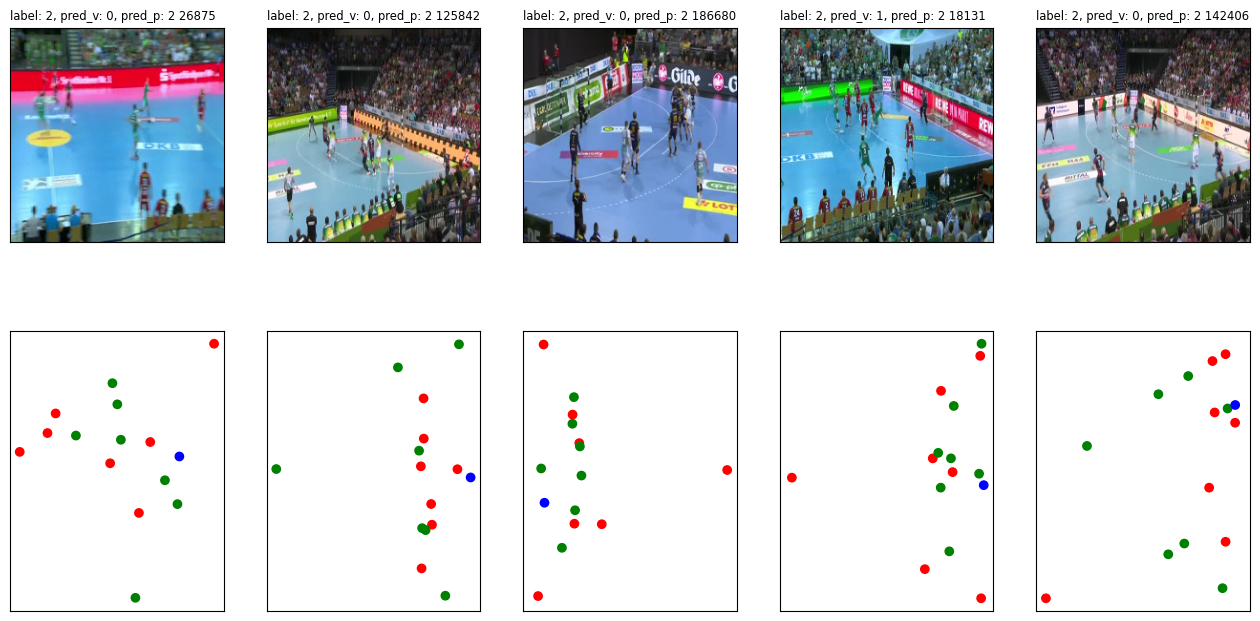

In [8]:
def renew_figure():
    plt.clf()
    fig, axis = plt.subplots(2, n, figsize=(16,8))
    return fig, axis

#TODO Put position and mvit labels in the title, also fix class indices
# dataset is for getting input data, df is cache from val run, video and pos pred are filtered preds
def animate_samples(dataset, df, n, video_pred, position_pred):
    fig, axis = renew_figure()
    sample_frames = []
    sample_positions = []
    sample_gt = []
    video_preds = []
    position_preds = []
    query_idx = []
    for i, sample in df.sample(n).iterrows():
        idx = i
        frames = dataset[idx]["frames"].numpy() # cthw
        positions = dataset[idx]["positions"].as_TNC(normalize=False)
        sample_frames.append(frames)
        sample_positions.append(positions)
        sample_gt.append(sample["ground_truths"])
        video_preds.append(video_pred.loc[idx, "predictions"])
        position_preds.append(position_pred.loc[idx, "predictions"])
        query_idx.append(idx)
    # list of 16 entries, each a list of n frames
    sample_frames = np.stack(sample_frames) # ncthw
    sample_frames = np.einsum("ncthw->nthwc", sample_frames)

    images = []
    for t in range(sample_frames.shape[1]):
        images_at_timestep = []
        for i in range(sample_frames.shape[0]):
            # video
            im = axis[0, i].imshow(sample_frames[i, t])
            axis[0, i].tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False
            )
            images_at_timestep.append(im)
            # positions
            colors = ["red", "green", "blue"]
            scatterplot = axis[1, i].scatter(
                x=sample_positions[i][t, :, 1],
                y=sample_positions[i][t, :, 2],
                c=[colors[int(m)] for m in sample_positions[i][t, :, 0]]
            )
            
            axis[1, i].tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False
            )
            axis[0, i].set_title(f"label: {sample_gt[i]}, pred_v: {video_preds[i]}, pred_p: {position_preds[i]} {query_idx[i]}", fontsize='small', loc='left')
            images_at_timestep.append(scatterplot)

        images.append(images_at_timestep)
        

    ani = animation.ArtistAnimation(fig, images, interval=50, blit=False, repeat_delay=1000)
    return ani

for c in label_decoder.get_classnames():
    label_int = label_decoder.get_classnames().index(c)
    n = 5
    animate_samples(dataset, v_df[(v_correct & p_correct) & (v_df["ground_truths"] == label_int)], n, v_df[(v_correct & p_correct) & (v_df["ground_truths"] == label_int)], p_df[(v_correct & p_correct) & (p_df["ground_truths"] == label_int)]).save(base_path / f"{c}_both_correct.gif", fps=10)
    animate_samples(dataset, v_df[(v_false & p_false) & (v_df["ground_truths"] == label_int)], n, v_df[(v_false & p_false) & (v_df["ground_truths"] == label_int)], p_df[(v_false & p_false) & (p_df["ground_truths"] == label_int)]).save(base_path / f"{c}_both_false.gif", fps=10)
    animate_samples(dataset, v_df[(v_correct & p_false) & (v_df["ground_truths"] == label_int)], n, v_df[(v_correct & p_false) & (v_df["ground_truths"] == label_int)], p_df[(v_correct & p_false) & (p_df["ground_truths"] == label_int)]).save(base_path / f"{c}_video_correct.gif", fps=10)
    animate_samples(dataset, v_df[(v_false & p_correct) & (v_df["ground_truths"] == label_int)], n, v_df[(v_false & p_correct) & (v_df["ground_truths"] == label_int)], p_df[(v_false & p_correct) & (p_df["ground_truths"] == label_int)]).save(base_path / f"{c}_positions_correct.gif", fps=10)


### Biggest loss difference

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

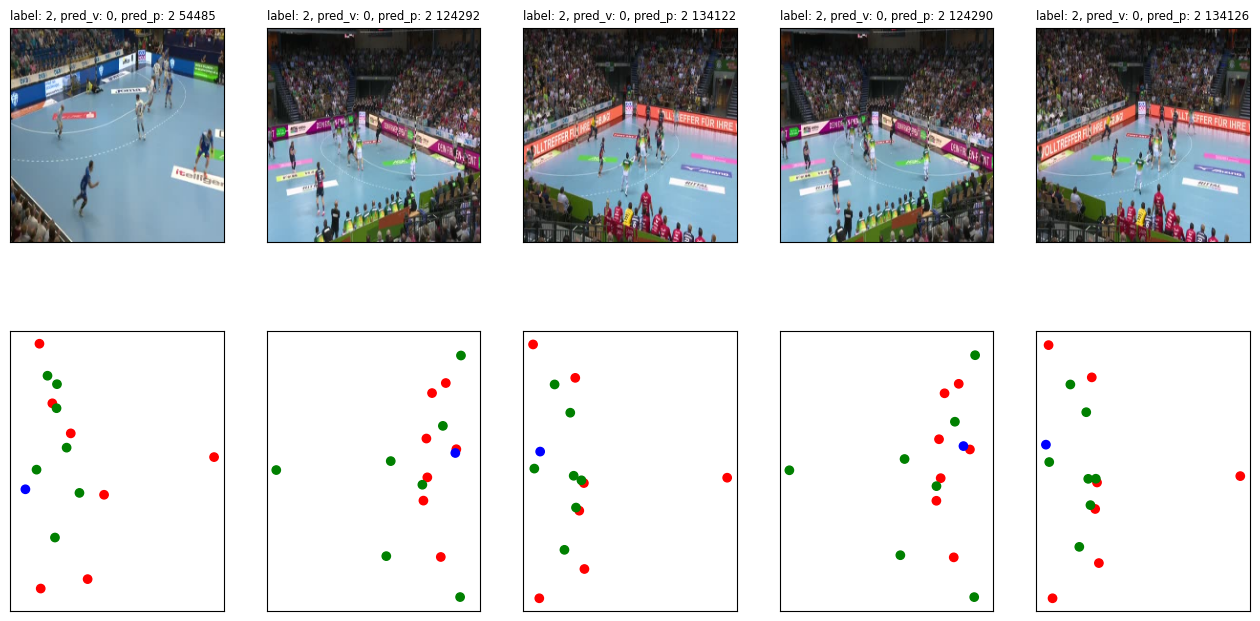

In [9]:
n = 5
for c in label_decoder.get_classnames():
    label_int = label_decoder.get_classnames().index(c)
    loss_difference = v_df[v_df["ground_truths"] == label_int]["loss"] - p_df[p_df["ground_truths"] == label_int]["loss"]
    video_better = loss_difference.iloc[loss_difference.argsort(axis="index")].head(n)
    positions_better = loss_difference.iloc[loss_difference.argsort(axis="index")].tail(n)
    animate_samples(dataset, v_df.iloc[video_better.index], n, v_df.iloc[video_better.index], p_df.iloc[video_better.index]).save(base_path / f"{c}_loss_video_better.gif", fps=10)
    animate_samples(dataset, v_df.iloc[positions_better.index], n, v_df.iloc[positions_better.index], p_df.iloc[positions_better.index]).save(base_path / f"{c}_loss_positions_better.gif", fps=10)
